## Read about fine grained classification on github and found BiCNN paper.

In [1]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os, h5py

In [3]:
from keras.layers import Input, Activation, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, SeparableConv2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPool2D
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Add, Concatenate, Multiply
from keras.optimizers import Adam, RMSprop, Nadam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K

In [4]:
ip_shp = (255, 143, 3)

In [5]:
m1 = VGG16(include_top=False, input_shape=ip_shp)
m2 = Model(m1.input, m1.get_layer(index=-2).output)
for layer in m2.layers: layer.trainable = False

In [8]:
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 255, 143, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 255, 143, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 255, 143, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 71, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 71, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 71, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 35, 128)       0         
__________

In [10]:
def bilinearpool(ip):
    phi_I = tf.einsum('ijkm,ijkn->imn',ip,ip)

    phi_I = tf.reshape(phi_I,[-1,512*512])

    phi_I = tf.divide(phi_I,784.0)  

    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))

    z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)
    
    return z_l2

In [11]:
ip = Input(ip_shp)
x = Lambda(preprocess_input)(ip)
x = m2(x)
x = Lambda(bilinearpool)(x)
x = Dense(2, activation='softmax')(x)
m = Model(ip, x)

In [12]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 255, 143, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 255, 143, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 15, 8, 512)        14714688  
_________________________________________________________________
lambda_2 (Lambda)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 524290    
Total params: 15,238,978
Trainable params: 524,290
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model_json = m.to_json()
with open("BiCNN.json", "w") as json_file:
    json_file.write(model_json)

In [14]:
class DataGenerator():
    def foo(self, x):
        return int(x.split('.')[1])
    
    def __init__(self, batch_size):
        self.path1 = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/0/'
        self.path2 = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/1/'
        self.batch_size = batch_size
        
        list0 = sorted(os.listdir(self.path1), key=self.foo)
        list0 = np.random.choice(list0, 50, replace=False)
        
        list1 = sorted(os.listdir(self.path2), key=self.foo)
        list1 = np.random.choice(list1, 50, replace=False)
        
        self.x_train = np.stack([np.array(Image.open(os.path.join(self.path1, l)), dtype=np.float) for l in list0])
        self.x_train = np.concatenate((self.x_train, np.stack([np.array(Image.open(os.path.join(self.path2, l)), dtype=np.float) for l in list1])))
        
        self.y_train = np.array([[1,0]]*50 + [[0,1]]*50, dtype=np.float)
        
    def flow(self):
        while True:
            indices = [np.random.randint(0,50), np.random.randint(50,100)]
            yield self.x_train[indices], self.y_train[indices]

In [15]:
class ValDataGenerator():
    def foo(self, x):
        return int(x.split('.')[1])
    
    def __init__(self):
        self.path1 = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/0/'
        self.path2 = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/1/'
        
        list0 = sorted(os.listdir(self.path1), key=self.foo)
        list0 = list0[110:130]
        
        list1 = sorted(os.listdir(self.path2), key=self.foo)
        list1 = list1[110:130]
        
        self.x_train = np.stack([np.array(Image.open(os.path.join(self.path1, l)), dtype=np.float) for l in list0])
        self.x_train = np.concatenate((self.x_train, np.stack([np.array(Image.open(os.path.join(self.path2, l)), dtype=np.float) for l in list1])))
        
        self.y_train = np.array([[1,0]]*20 + [[0,1]]*20, dtype=np.float)
        
    def flow(self):
        return self.x_train, self.y_train

with h5py.File('/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/probs.h5', 'r') as hdf:
    y2 = np.array(hdf.get('prob2'))
    y1 = np.array(hdf.get('prob1'))
    y0 = np.array(hdf.get('prob0'))

y_train = np.concatenate((y2[:84], y1[:42], y0[:42]))

traingen = DataGenerator(2)

In [12]:
path = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized'
traingen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(path, target_size=ip_shp[:2], batch_size=8)

Found 302 images belonging to 2 classes.


In [839]:
m.save('/home/aaditya/Documents/pytest2/neural-style-keras-master/BilinearVGG16_1.h5')

In [14]:
checkpoint_path = '/home/aaditya/Documents/pytest2/neural-style-keras-master/BilinearVGG16_1.h5'

#### Best Weights
checkpoint_path = '/home/aaditya/Documents/pytest2/neural-style-keras-master/2_channel_SEclsfr_maxpool1.h5' 0.85 accuracy

In [558]:
m.save_weights(checkpoint_path)

In [13]:
m.compile(RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
callbacks = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, save_weights_only=False)

In [36]:
K.set_value(m.optimizer.lr, 0.00001)

In [37]:
history = m.fit_generator(testgen, steps_per_epoch=16, callbacks=[callbacks], epochs=4, max_queue_size=12)
#m.fit_generator(gen.flow(x_train, y_train, batch_size=2), steps_per_epoch=8, epochs=9)
#m.fit_generator(gen.flow(x_train, y_train, batch_size=2), steps_per_epoch=8, epochs=9)

Epoch 1/4
15/16 [===========================>..] - ETA: 0s - loss: 0.3020 - acc: 0.8917
Epoch 00001: loss did not improve
16/16 [==============================] - 8s 505ms/step - loss: 0.2930 - acc: 0.8984
Epoch 2/4
15/16 [===========================>..] - ETA: 0s - loss: 0.2784 - acc: 0.9083
Epoch 00002: loss improved from 0.27616 to 0.27363, saving model to /home/aaditya/Documents/pytest2/neural-style-keras-master/BilinearVGG16_1.h5
16/16 [==============================] - 9s 542ms/step - loss: 0.2736 - acc: 0.9141
Epoch 3/4
15/16 [===========================>..] - ETA: 0s - loss: 0.2838 - acc: 0.9167
Epoch 00003: loss did not improve
16/16 [==============================] - 8s 505ms/step - loss: 0.2793 - acc: 0.9219
Epoch 4/4
15/16 [===========================>..] - ETA: 0s - loss: 0.2623 - acc: 0.9333
Epoch 00004: loss improved from 0.27363 to 0.25559, saving model to /home/aaditya/Documents/pytest2/neural-style-keras-master/BilinearVGG16_1.h5
16/16 [==============================]

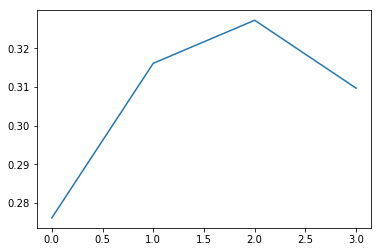

In [34]:
plt.plot(history.history['loss'])

In [35]:
m.evaluate_generator(testgen)

[0.28063947205640832, 0.91326530612244894]

In [18]:
testdir = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/test'

In [19]:
testgen = ImageDataGenerator().flow_from_directory(testdir, target_size=ip_shp[:-1], batch_size=8)

Found 392 images belonging to 2 classes.


In [69]:
a, b = testgen.next()

In [70]:
i = 0

0 pred:  0


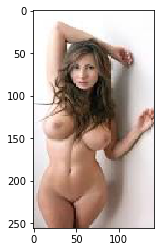

In [72]:
plt.imshow(a[i].astype('uint8')); print(np.argmax(b[i]), 'pred: ', np.argmax(m.predict(a[i:i+1])))
i+=1

In [891]:
i=0

a = m.predict(x_train[0:1])

a

y_train[0]

for layer in m.layers[43:]: layer.trainable=True
ip = m.input
o1 = m.output
x = Dense(3, activation='softmax')(o1)
M = Model(inputs=ip, outputs=x)

M.summary()

M = create_model()

M.compile(RMSprop(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = '/home/aaditya/Documents/pytest2/neural-style-keras-master/onlyfinecls2.h5'

callbacks = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='acc', verbose=1, save_best_only=True, save_weights_only=False)

traingen = ImageDataGenerator().flow_from_directory('/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized', target_size=(513, 385), batch_size=2)

M.fit_generator(traingen, steps_per_epoch=8, epochs=2, callbacks=[callbacks], validation_data=traingen, validation_steps=3)
#M.fit_generator(gen.flow(x_train, y_train, batch_size=2), steps_per_epoch=8, epochs=9)
#M.fit_generator(gen.flow(x_train, y_train, batch_size=2), steps_per_epoch=8, epochs=9)

a, b = traingen.next()

plt.imshow(a[0].astype('uint8'))

b

np.argmax(M.predict(a), axis=1)

mbnet = xception.Xception(input_shape=ip_shp, weights=None, include_top=True)

mbnet.load_weights('/home/aaditya/Documents/pytest2/xception_weights_tf_dim_ordering_tf_kernels.h5')

out = mbnet.get_layer('avg_pool').output
mbnet_bot = Model(mbnet.input, out)

testx = Image.open('/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/2/0.63.jpg')
testx = np.array(testx, dtype=np.float)
testx = np.expand_dims(testx, 0)

testx = xception.preprocess_input(testx)

testx.shape

xception.decode_predictions(mbnet.predict(testx))

path = '/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/imgs_resized/2'
items = sorted(os.listdir(path), key=foo)

all_probs2 = []
for item in items:
    im = Image.open(os.path.join(path, item))
    im = np.expand_dims(np.array(im, dtype=np.float), 0)
    im = xception.preprocess_input(im)
    prob = mbnet_bot.predict(im)
    all_probs2.append(prob)
all_probs2 = np.array(all_probs2)

all_probs2.shape

prob2 = np.reshape(all_probs2, (124, 2048))

prob0.shape

prob1.shape

prob2.shape

with h5py.File('/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/probs.h5', 'r') as hdf:
    prob0 = hdf.get('prob0')
    prob0 = np.array(prob0)

with h5py.File('/home/aaditya/Documents/pytest2/neural-style-keras-master/content_imgs/probs.h5', 'w') as hdf:
    hdf.create_dataset('prob0', data=prob0)
    hdf.create_dataset('prob1', data=prob1)
    hdf.create_dataset('prob2', data=prob2)

os.listdir(path)

idx = [os.listdir(path)[i].split('.')[1] for i in range(len(os.listdir(path)))]

sorted(os.listdir(path), key=foo)

def foo(x):
    return int(x.split('.')[1])